<a href="https://colab.research.google.com/github/Priyanshiguptaaa/CS5787-DeepLearning-Assignment1/blob/main/dl_ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting & Previewing data

In [1]:
import zipfile
import os

# Path to the uploaded .zip file (in Colab, it's usually in /content/)
zip_file_path = '/content/data-1.zip'

# Unzipping the data-1.zip file to a folder named 'unzipped_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped_data')

# Check the contents of the unzipped folder
os.listdir('/content/unzipped_data')

['__MACOSX', 'data']

In [14]:
import gzip
import shutil
import os

# Path to the folder where the .gz files are extracted
input_folder = '/content/unzipped_data/data'

# Iterate through each file in the input folder and unzip the .gz files
for filename in os.listdir(input_folder):
    if filename.endswith('.gz'):
        file_path = os.path.join(input_folder, filename)

        # Create output file path by removing the '.gz' extension
        output_file = file_path.replace('.gz', '')

        # Unzip the file
        with gzip.open(file_path, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f'Unzipped: {filename} to {output_file}')

Unzipped: train-images-idx3-ubyte.gz to /content/unzipped_data/data/train-images-idx3-ubyte
Unzipped: test-images-idx3-ubyte.gz to /content/unzipped_data/data/test-images-idx3-ubyte
Unzipped: train-labels-idx1-ubyte.gz to /content/unzipped_data/data/train-labels-idx1-ubyte
Unzipped: test-labels-idx1-ubyte.gz to /content/unzipped_data/data/test-labels-idx1-ubyte


In [15]:
import numpy as np
import struct
import matplotlib.pyplot as plt

def read_idx(filename):
    """
    Reads an IDX file and returns the data as a numpy array.
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

train_images_path = '/content/unzipped_data/data/train-images-idx3-ubyte'
train_labels_path = '/content/unzipped_data/data/train-labels-idx1-ubyte'
test_images_path = '/content/unzipped_data/data/test-images-idx3-ubyte'
test_labels_path = '/content/unzipped_data/data/test-labels-idx1-ubyte'

# Read train images and labels
train_images = read_idx(train_images_path)
train_labels = read_idx(train_labels_path)

# Read train images and labels
test_images = read_idx(test_images_path)
test_labels = read_idx(test_labels_path)

In [16]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Train Labels Shape: {test_labels.shape}")

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Train Labels Shape: (10000,)


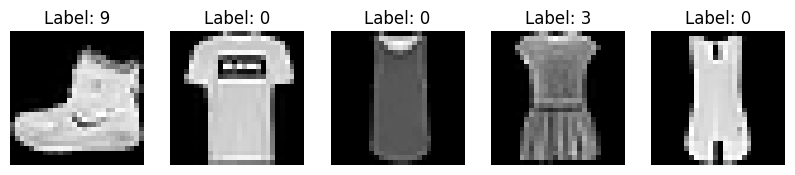

In [17]:
def preview_images(images, labels, num_images=5):
    """
    Preview the first num_images images from the dataset.
    """
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Preview the first 5 images from the training set
preview_images(train_images, train_labels, num_images=5)

# Preprocessing

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

train_images_tensor = torch.from_numpy(train_images).float()
train_labels_tensor = torch.from_numpy(train_labels).long()

test_images_tensor = torch.from_numpy(test_images).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

In [19]:
# Reshape to add the channel dimension (1 channel for grayscale images)
train_images_tensor = train_images_tensor.unsqueeze(1)  # Result: (60000, 1, 28, 28)
test_images_tensor = test_images_tensor.unsqueeze(1)    # Result: (10000, 1, 28, 28)

In [20]:
# Normalize pixels
train_images_tensor /= 255.0
test_images_tensor /= 255.0

In [21]:
from sklearn.model_selection import train_test_split
train_images_np, val_images_np, train_labels_np, val_labels_np = train_test_split(
    train_images_tensor.numpy(), train_labels_tensor.numpy(), test_size=0.2, random_state=42)

In [22]:
# Convert numpy arrays back to tensors
train_images_tensor = torch.from_numpy(train_images_np).float()
train_labels_tensor = torch.from_numpy(train_labels_np).long()
val_images_tensor = torch.from_numpy(val_images_np).float()
val_labels_tensor = torch.from_numpy(val_labels_np).long()

In [23]:
# Create datasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [24]:
# Display the number of samples in each set
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 48000
Number of validation samples: 12000
Number of test samples: 10000


In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Lenet5 Architecture

In [26]:
class LeNet5(nn.Module):
    def __init__(self):
      super(LeNet5, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
      self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
      self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
      self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
      self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
      self.fc1 = nn.Linear(in_features=120, out_features=84)
      self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
      x = F.tanh(self.conv1(x))
      #x.shape = (batch_size,6,28,28)

      x = self.pool1(x)
      #x.shape = (batch_size,6,14,14)

      x = F.tanh(self.conv2(x))
      #x.shape = (batch_size,16,10,10)

      x = self.pool2(x)
      #x.shape = (batch_size,16,5,5)

      x = F.relu(self.conv3(x))
      #x.shape = (batch_size,120,1,1)

      x = x.view(-1, 120)
      x = F.relu(self.fc1(x))
      x = self.fc2(x) # apply softmax separately during training

      return x

In [27]:
class LeNet5Dropout(nn.Module):
    def __init__(self):
        super(LeNet5Dropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = self.pool1(x)
        x = F.tanh(self.conv2(x))
        x = self.pool2(x)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before final layer
        x = self.fc2(x)
        return x

In [28]:
class LeNet5BatchNorm(nn.Module):
    def __init__(self):
        super(LeNet5BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(120)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.tanh(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.tanh(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.tanh(self.bn3(self.conv3(x)))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [43]:
import torch.optim as optim

def train_model(model, optimizer, criterion, train_loader, val_loader, test_loader, num_epochs=10, use_dropout=False, save_path=None):
    train_loss_history, train_acc_history, val_acc_history, test_acc_history = [], [], [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Enable dropout and batch normalization
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Check if we need to temporarily disable dropout for accuracy measurement
        if use_dropout:
            model.eval()  # Disable dropout

        # Calculate training accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_loader:  # Measure accuracy on the training set
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(train_accuracy)

        # Switch back to training mode if dropout is being used
        if use_dropout:
            model.train()

        # Evaluate on the validation set
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_acc_history.append(val_accuracy)

        # Evaluate on the test set
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_acc_history.append(test_accuracy)

        # Print statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")

        # Save model weights after every epoch if save_path is provided
        if save_path:
            torch.save(model.state_dict(), f'{save_path}_epoch_{epoch+1}.pth')

    return train_loss_history, train_acc_history, val_acc_history, test_acc_history


Without Regularization

In [44]:
# Define the model
model = LeNet5()  # Or any other model

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and save the weights
train_loss, train_acc, val_acc, test_acc = train_model(
    model, optimizer, criterion, train_loader, val_loader, test_loader, num_epochs=10, use_dropout=False, save_path='model_no_reg'
)


Epoch [1/10], Loss: 0.7204, Train Accuracy: 80.90%, Validation Accuracy: 80.44%, Test Accuracy: 79.39%
Epoch [2/10], Loss: 0.4713, Train Accuracy: 84.61%, Validation Accuracy: 84.09%, Test Accuracy: 83.15%
Epoch [3/10], Loss: 0.4091, Train Accuracy: 85.19%, Validation Accuracy: 84.62%, Test Accuracy: 83.89%
Epoch [4/10], Loss: 0.3715, Train Accuracy: 87.15%, Validation Accuracy: 86.30%, Test Accuracy: 85.34%
Epoch [5/10], Loss: 0.3413, Train Accuracy: 88.02%, Validation Accuracy: 87.22%, Test Accuracy: 86.37%
Epoch [6/10], Loss: 0.3204, Train Accuracy: 88.15%, Validation Accuracy: 86.88%, Test Accuracy: 86.43%
Epoch [7/10], Loss: 0.3041, Train Accuracy: 89.37%, Validation Accuracy: 88.14%, Test Accuracy: 87.63%
Epoch [8/10], Loss: 0.2902, Train Accuracy: 90.18%, Validation Accuracy: 88.57%, Test Accuracy: 88.21%
Epoch [9/10], Loss: 0.2743, Train Accuracy: 89.95%, Validation Accuracy: 88.27%, Test Accuracy: 87.74%
Epoch [10/10], Loss: 0.2637, Train Accuracy: 90.95%, Validation Accuracy:

In [46]:
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


With Dropout

In [47]:
# Initialize the model with Dropout
model_dropout = LeNet5Dropout()
model_dropout.to(device)

# Define the optimizer
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)

# Train the model with dropout and validate
train_loss_dropout, train_acc_dropout, val_acc_dropout, test_acc_dropout = train_model(
    model_dropout, optimizer_dropout, criterion, train_loader, val_loader, test_loader, num_epochs=10, use_dropout=True, save_path='model_dropout'
)

Epoch [1/10], Loss: 0.6641, Train Accuracy: 83.78%, Validation Accuracy: 83.28%, Test Accuracy: 82.53%
Epoch [2/10], Loss: 0.4393, Train Accuracy: 86.10%, Validation Accuracy: 85.61%, Test Accuracy: 84.74%
Epoch [3/10], Loss: 0.3839, Train Accuracy: 87.70%, Validation Accuracy: 86.88%, Test Accuracy: 86.09%
Epoch [4/10], Loss: 0.3578, Train Accuracy: 87.98%, Validation Accuracy: 87.24%, Test Accuracy: 86.09%
Epoch [5/10], Loss: 0.3371, Train Accuracy: 88.78%, Validation Accuracy: 87.67%, Test Accuracy: 86.66%
Epoch [6/10], Loss: 0.3202, Train Accuracy: 89.16%, Validation Accuracy: 88.14%, Test Accuracy: 87.01%
Epoch [7/10], Loss: 0.3084, Train Accuracy: 89.48%, Validation Accuracy: 88.08%, Test Accuracy: 87.19%
Epoch [8/10], Loss: 0.2958, Train Accuracy: 90.19%, Validation Accuracy: 88.61%, Test Accuracy: 87.95%
Epoch [9/10], Loss: 0.2855, Train Accuracy: 90.31%, Validation Accuracy: 88.49%, Test Accuracy: 87.91%
Epoch [10/10], Loss: 0.2731, Train Accuracy: 91.04%, Validation Accuracy:

In [48]:
print(model_dropout)

LeNet5Dropout(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


With Weight Decay

In [35]:
import torch.optim as optim

# List of weight decay values to test
weight_decays = [1e-5, 1e-4, 1e-3, 1e-2]

for wd in weight_decays:
    # Initialize the model for each weight decay value
    model_wd = LeNet5()
    model_wd.to(device)

    # Define the optimizer with the current weight decay value
    optimizer_wd = optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=wd)

    # Train the model with the current weight decay
    train_loss_wd, train_acc_wd, val_acc_wd, test_acc_wd = train_model(
        model_wd, optimizer_wd, criterion, train_loader, val_loader, test_loader, num_epochs=10, use_dropout=False
    )

    # Print final accuracies
    print(f"Weight Decay: {wd}")
    print(f"Final Train Accuracy: {train_acc_wd[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_acc_wd[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_acc_wd[-1]:.2f}%")


Epoch [1/10], Loss: 0.6781, Train Accuracy: 83.22%, Validation Accuracy: 82.77%, Test Accuracy: 82.26%
Epoch [2/10], Loss: 0.4371, Train Accuracy: 85.73%, Validation Accuracy: 85.00%, Test Accuracy: 84.21%
Epoch [3/10], Loss: 0.3765, Train Accuracy: 87.03%, Validation Accuracy: 86.35%, Test Accuracy: 85.54%
Epoch [4/10], Loss: 0.3443, Train Accuracy: 88.28%, Validation Accuracy: 87.19%, Test Accuracy: 86.87%
Epoch [5/10], Loss: 0.3253, Train Accuracy: 88.21%, Validation Accuracy: 87.05%, Test Accuracy: 86.16%
Epoch [6/10], Loss: 0.3040, Train Accuracy: 89.06%, Validation Accuracy: 87.83%, Test Accuracy: 86.89%
Epoch [7/10], Loss: 0.2903, Train Accuracy: 89.68%, Validation Accuracy: 87.97%, Test Accuracy: 87.61%
Epoch [8/10], Loss: 0.2751, Train Accuracy: 90.07%, Validation Accuracy: 88.08%, Test Accuracy: 87.71%
Epoch [9/10], Loss: 0.2617, Train Accuracy: 90.99%, Validation Accuracy: 89.06%, Test Accuracy: 88.38%
Epoch [10/10], Loss: 0.2516, Train Accuracy: 91.20%, Validation Accuracy:

In [49]:
# Initialize the model
model_wd = LeNet5()
model_wd.to(device)

# Define the optimizer with weight decay
optimizer_wd = optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
train_loss_wd, train_acc_wd, val_acc_wd, test_acc_wd = train_model(
    model_wd, optimizer_wd, criterion, train_loader, val_loader, test_loader, num_epochs=10, use_dropout=False, save_path='model_weight_decay'
)

# Print final accuracies
print(f"Final Train Accuracy: {train_acc_wd[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc_wd[-1]:.2f}%")
print(f"Final Test Accuracy: {test_acc_wd[-1]:.2f}%")


Epoch [1/10], Loss: 0.7025, Train Accuracy: 81.92%, Validation Accuracy: 81.38%, Test Accuracy: 80.92%
Epoch [2/10], Loss: 0.4487, Train Accuracy: 84.80%, Validation Accuracy: 84.29%, Test Accuracy: 83.47%
Epoch [3/10], Loss: 0.3846, Train Accuracy: 86.99%, Validation Accuracy: 86.61%, Test Accuracy: 85.54%
Epoch [4/10], Loss: 0.3504, Train Accuracy: 88.11%, Validation Accuracy: 87.37%, Test Accuracy: 86.52%
Epoch [5/10], Loss: 0.3261, Train Accuracy: 88.31%, Validation Accuracy: 87.56%, Test Accuracy: 86.67%
Epoch [6/10], Loss: 0.3062, Train Accuracy: 89.24%, Validation Accuracy: 88.10%, Test Accuracy: 87.06%
Epoch [7/10], Loss: 0.2896, Train Accuracy: 89.95%, Validation Accuracy: 88.78%, Test Accuracy: 88.05%
Epoch [8/10], Loss: 0.2787, Train Accuracy: 89.37%, Validation Accuracy: 88.07%, Test Accuracy: 87.06%
Epoch [9/10], Loss: 0.2656, Train Accuracy: 90.89%, Validation Accuracy: 89.27%, Test Accuracy: 88.43%
Epoch [10/10], Loss: 0.2560, Train Accuracy: 90.55%, Validation Accuracy:

In [50]:
print(model_wd)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


With Batch Normalization

In [51]:
# Initialize the model with Batch Normalization
model_bn = LeNet5BatchNorm()
model_bn.to(device)

# Define the optimizer
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

# Train the model
train_loss_bn, train_acc_bn, val_acc_bn, test_acc_bn = train_model(
    model_bn, optimizer_bn, criterion, train_loader, val_loader, test_loader, num_epochs=10, use_dropout=False, save_path='model_batch_norm'
)

# Print final accuracies
print(f"Final Train Accuracy: {train_acc_bn[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc_bn[-1]:.2f}%")
print(f"Final Test Accuracy: {test_acc_bn[-1]:.2f}%")

Epoch [1/10], Loss: 0.4905, Train Accuracy: 87.32%, Validation Accuracy: 86.89%, Test Accuracy: 86.38%
Epoch [2/10], Loss: 0.3397, Train Accuracy: 88.46%, Validation Accuracy: 87.67%, Test Accuracy: 86.96%
Epoch [3/10], Loss: 0.3009, Train Accuracy: 89.89%, Validation Accuracy: 88.85%, Test Accuracy: 88.29%
Epoch [4/10], Loss: 0.2743, Train Accuracy: 90.68%, Validation Accuracy: 89.42%, Test Accuracy: 88.86%
Epoch [5/10], Loss: 0.2563, Train Accuracy: 91.03%, Validation Accuracy: 89.57%, Test Accuracy: 89.08%
Epoch [6/10], Loss: 0.2395, Train Accuracy: 92.37%, Validation Accuracy: 90.39%, Test Accuracy: 89.88%
Epoch [7/10], Loss: 0.2269, Train Accuracy: 92.35%, Validation Accuracy: 90.02%, Test Accuracy: 89.84%
Epoch [8/10], Loss: 0.2141, Train Accuracy: 93.10%, Validation Accuracy: 90.30%, Test Accuracy: 89.83%
Epoch [9/10], Loss: 0.1991, Train Accuracy: 93.59%, Validation Accuracy: 90.47%, Test Accuracy: 90.13%
Epoch [10/10], Loss: 0.1860, Train Accuracy: 94.04%, Validation Accuracy:

In [52]:
print(model_bn)

LeNet5BatchNorm(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


Plotting Results

In [53]:
import matplotlib.pyplot as plt

def plot_convergence(train_acc, val_acc, test_acc, title_prefix):
    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.plot(train_acc, label='Training Accuracy', color='blue', linestyle='-')

    # Plot Validation Accuracy
    plt.plot(val_acc, label='Validation Accuracy', color='green', linestyle='--')

    # Plot Test Accuracy
    plt.plot(test_acc, label='Test Accuracy', color='red', linestyle='-.')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title_prefix} - Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.savefig(f'{title_prefix}_convergence.png')
    plt.close()

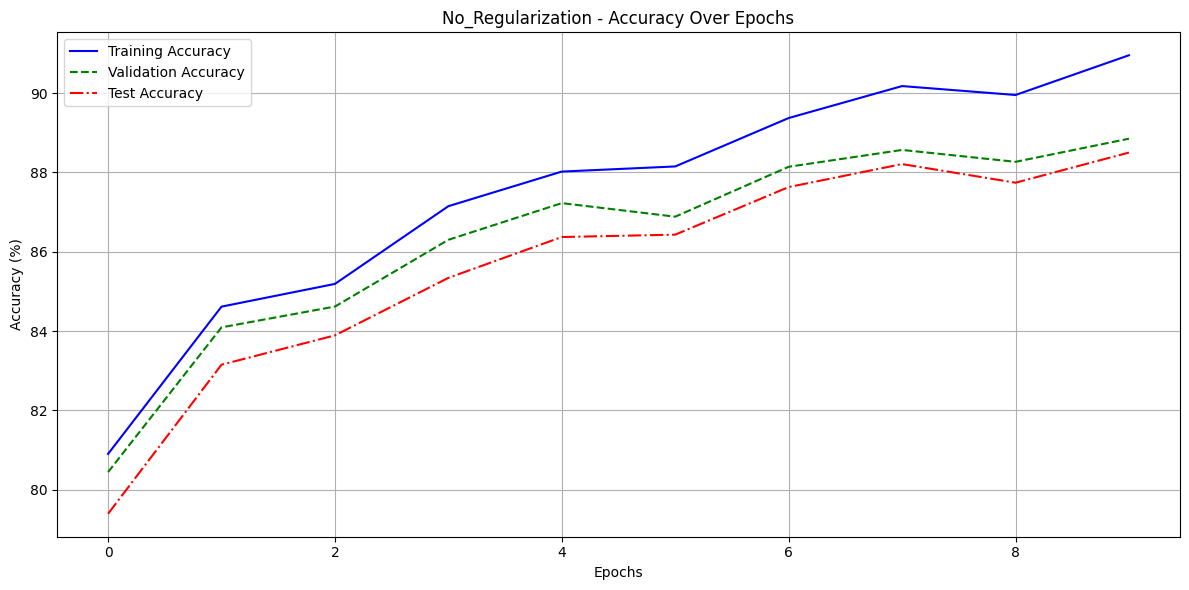

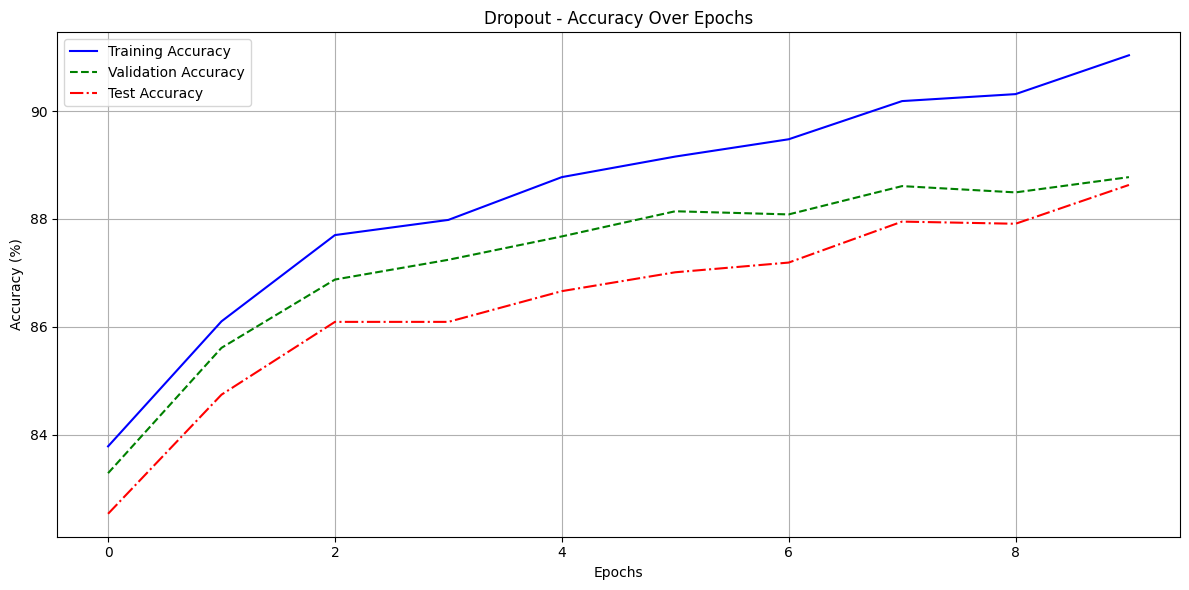

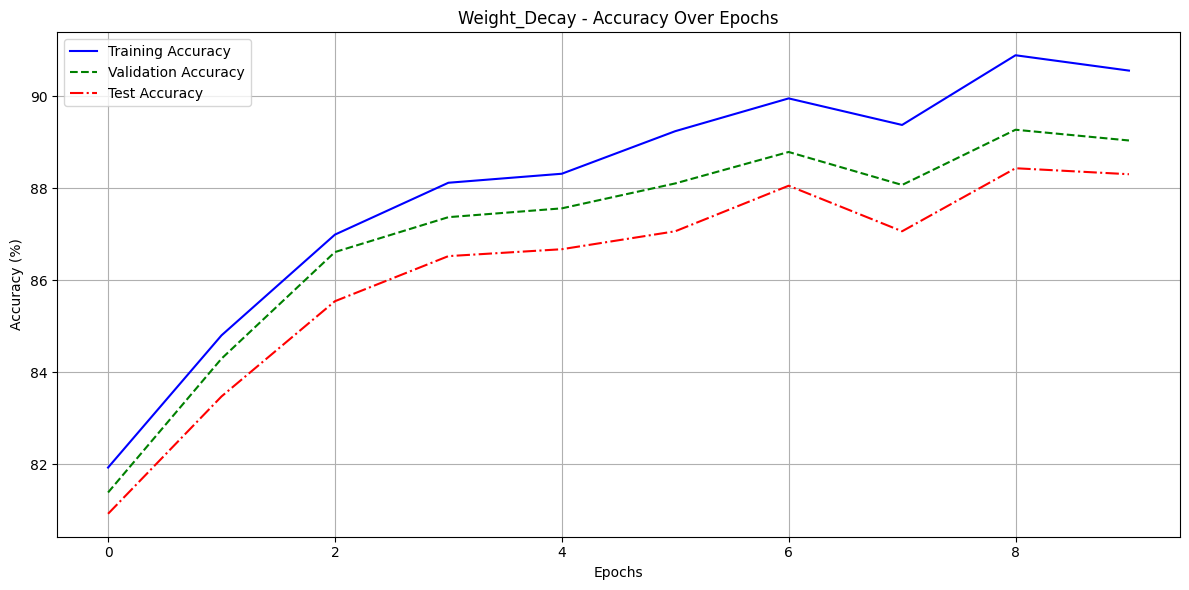

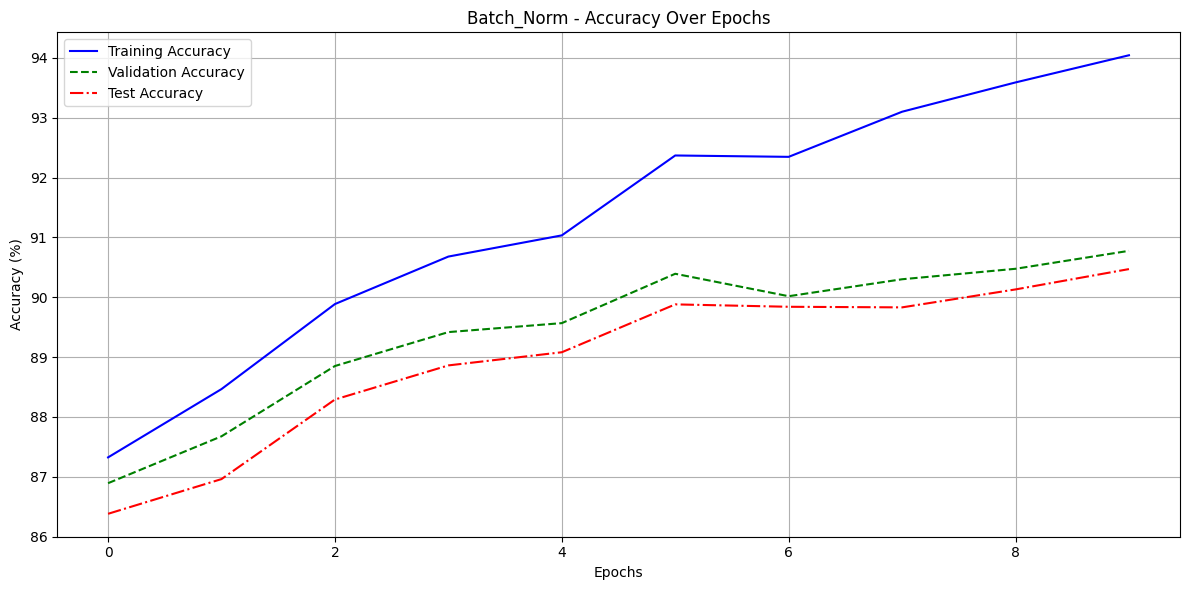

In [54]:
plot_convergence(train_acc, val_acc, test_acc, 'No_Regularization')
plot_convergence(train_acc_dropout, val_acc_dropout, test_acc_dropout, 'Dropout')
plot_convergence(train_acc_wd, val_acc_wd, test_acc_wd, 'Weight_Decay')
plot_convergence(train_acc_bn, val_acc_bn, test_acc_bn, 'Batch_Norm')

Summary Table

In [55]:
import pandas as pd

# Create a DataFrame for final accuracies
data = {
    'Technique': ['No Regularization', 'Dropout', 'Weight Decay', 'Batch Norm'],
    'Train Accuracy (%)': [
        train_acc[-1],
        train_acc_dropout[-1],
        train_acc_wd[-1],
        train_acc_bn[-1]
    ],
    'Validation Accuracy (%)': [
        val_acc[-1],
        val_acc_dropout[-1],
        val_acc_wd[-1],
        val_acc_bn[-1]
    ],
    'Test Accuracy (%)': [
        test_acc[-1],
        test_acc_dropout[-1],
        test_acc_wd[-1],
        test_acc_bn[-1]
    ]
}

df = pd.DataFrame(data)
df.to_csv('final_accuracies.csv', index=False)
print(df)


           Technique  Train Accuracy (%)  Validation Accuracy (%)  \
0  No Regularization           90.954167                88.850000   
1            Dropout           91.035417                88.775000   
2       Weight Decay           90.552083                89.033333   
3         Batch Norm           94.043750                90.775000   

   Test Accuracy (%)  
0              88.50  
1              88.63  
2              88.30  
3              90.47  


In [ ]:
›